In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import matplotlib.cm as cm
import matplotlib
!pip install nibabel
import nibabel as nib
import subprocess
from ipywidgets import interact, IntSlider
import torch
import torch.nn as nn
import torch.nn.functional as F

conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
#prueba= torch.tensor(img[:,:,6,9]).float()

#prueba = prueba.unsqueeze(0).unsqueeze(0)
#prueba.shape
import seaborn as sns
sns.set_style("dark")
cmap = plt.get_cmap('viridis')

/home/jorge/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Visualization of one single specimen

DS_path = "/home/jorge/work_dir/federado/OpenDataset/"
path = "/home/jorge/work_dir/federado/OpenDataset/A5C2D2/A5C2D2_sa.nii"
path_gt = "/home/jorge/work_dir/federado/OpenDataset/A5C2D2/A5C2D2_sa_gt.nii"

img = nib.load(path).get_fdata()
img_gt = nib.load(path_gt).get_fdata()

print(np.min(img), np.max(img), img.shape, type(img))
print(np.min(img_gt), np.max(img_gt), img.shape, type(img_gt))
def show_slice(z_axis, t_axis,):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    imgSlice = img[:,:,z_axis, t_axis]
    imgSlice_gt = img_gt[:,:,z_axis,t_axis]    
    axes[0].imshow(imgSlice, cmap='viridis')
    axes[0].axis('off')
    axes[1].imshow(imgSlice_gt) #, cmap='Greys')
    axes[1].axis('off')
    plt.show()
x_dim, y_dim, z_dim, t_dim = img.shape[:]

z_axis_slider = IntSlider(min=0, max=z_dim-1, step=1, value=0, description='Z axis')
t_axis_slider = IntSlider(min=0, max=t_dim-1, step=1, value=0, description='T axis')

interact(show_slice, z_axis=z_axis_slider, t_axis=t_axis_slider);


0.0 4785.78515625 (288, 288, 10, 25) <class 'numpy.memmap'>
0.0 3.0 (288, 288, 10, 25) <class 'numpy.memmap'>


interactive(children=(IntSlider(value=0, description='Z axis', max=9), IntSlider(value=0, description='T axis'…

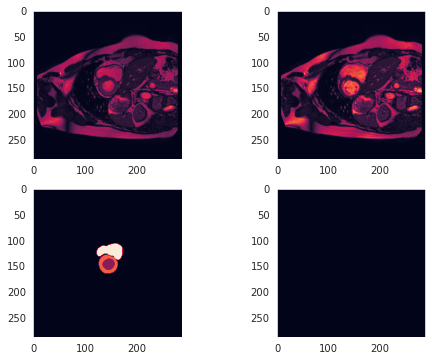

In [3]:
# ¿Lack of mask in certain slices?
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
# Slices [:,:,6,9]
axes[0,0].imshow(img[:,:,6,9])
axes[1,0].imshow(img_gt[:,:,6,9])
# Slices [:,:,6,19]
axes[0,1].imshow(img[:,:,6,19])
axes[1,1].imshow(img_gt[:,:,6,19])

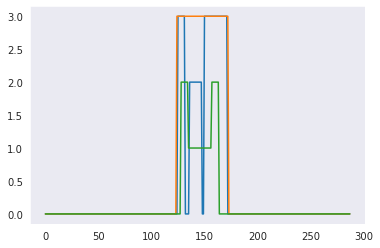

In [4]:
plt.plot(img_gt[130,:,6,9])
plt.plot(img_gt[120,:,6,9])
plt.plot(img_gt[150,:,6,9])

In [5]:
# Creamos un tensor de prueba con dimensiones [batch_size, canales, altura, ancho]
# Por ejemplo, un tensor de prueba de tamaño 1x3x32x32
batch_size = 1
canales = 1
altura = 288
ancho = 288
tensor_prueba = torch.randn(batch_size, canales, altura, ancho)
tensor_prueba[0,0,:,:] = torch.tensor(img[:,:,6,9]).to(torch.double)
# Definimos una capa de convolución
# Supongamos que queremos aplicar 5 filtros de tamaño 3x3 a la entrada de 3 canales
# con un relleno (padding) de 1 y un paso (stride) de 1
capa_conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1, stride=1)

# Pasamos el tensor de prueba a través de la capa convolucional
resultado = capa_conv(tensor_prueba)

# Visualizamos las dimensiones del tensor resultante
print("Dimensiones del tensor de prueba:", tensor_prueba.shape)
print("Dimensiones del tensor resultante:", resultado.shape)

Dimensiones del tensor de prueba: torch.Size([1, 1, 288, 288])
Dimensiones del tensor resultante: torch.Size([1, 5, 288, 288])


In [6]:
mm=torch.load("/home/jorge/work_dir/federado/Federado/ssh_version/data/MMs/MMs_1.pt")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jorge/work_dir/federado/Federado/ssh_version/data/MMs/MMs_1.pt'

In [ ]:
prueba = mm[0]["image"]
prueba = prueba.unsqueeze(0).unsqueeze(0).float()
prueba.shape
prueba_mask=mm[0]["mask"]
prueba_mask = prueba_mask.unsqueeze(0).unsqueeze(0)
#conv(prueba).shape
print(prueba.shape)
print(prueba_mask.shape)

In [ ]:
"""
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
"""
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        ############### Este tipo de hiperparámetros deberían estar incluídos
        # también en el input y por lo tanto en utils::Parameters
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        
        return x2
    
red = UNet(1,1)

In [ ]:
ejemplar = 0
prueba = mm[ejemplar]["image"]
prueba = prueba.unsqueeze(0).unsqueeze(0).float()

prueba_mask=mm[ejemplar]["mask"]
prueba_mask = prueba_mask.unsqueeze(0).unsqueeze(0)

output = red.forward(prueba)

print(prueba.shape)
print(output.shape)

In [ ]:
prueba = mm[ejemplar]["image"]
plt.imshow(prueba)


In [ ]:
prueba = prueba.unsqueeze(0).unsqueeze(0).float()
output = red.forward(prueba)
salida = output[0,0,:,:].detach().numpy()
plt.imshow(salida)

In [ ]:
prueba_mask=mm[ejemplar]["mask"]
mask = prueba_mask.detach().numpy()
plt.imshow(mask)

In [ ]:
class DownscalingBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DownscalingBlock,self).__init__()
        mid_channels = out_channels
        self.conv_reduction = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return self.conv_reduction(x)

# __________________________________________________________________________________-

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

# __________________________________________________________________________________

    
class UpscalingBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UpscalingBlock,self).__init__()
        ##### mid channels = output channels cuando se usa convTranspose
        mid_channels = out_channels
        ##### mid channels = in_channels // 2 cuando se usa bilinear
        mid_channels = in_channels // 2
        self.augmentation = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)    
        self.convolution = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, res):
        x = self.augmentation(x)
        
        diffY = res.size()[2] - x.size()[2]
        diffX = res.size()[3] - x.size()[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([res, x], dim=1)
        return self.convolution(x)


class InitialLayer(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(InitialLayer,self).__init__()
        self.initial = nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1, bias=False)

    def forward(self,x):
        return self.initial(x)

class FinalLayer(nn.Module):
    def __init__(self,in_channels,n_classes):
        super(FinalLayer,self).__init__()
        self.final = nn.Conv2d(in_channels,n_classes,kernel_size=3, padding=1, bias=False)

    def forward(self,x):
        return self.final(x)

n_classes=3
inicial = InitialLayer(1,64)
down1 = (DownscalingBlock(64, 128))
down2 = (DownscalingBlock(128, 256))
down3 = (DownscalingBlock(256, 512))
factor = 2  #if bilinear else 1
down4 = (DownscalingBlock(512, 1024 // factor))
up1 = (UpscalingBlock(1024, 512 // factor))
up2 = (UpscalingBlock(512, 256 // factor))
up3 = (UpscalingBlock(256, 128 // factor))
up4 = (UpscalingBlock(128, 64))
final = FinalLayer(64, n_classes)

In [ ]:

prueba = mm[ejemplar]["image"]
prueba = prueba.unsqueeze(0).unsqueeze(0).float()
salida0 =inicial(prueba)
print("Inicial",prueba.shape)
salida1=down1(salida0)
print("Salida 1", salida1.shape)
salida2=down2(salida1)
print("Salida 2", salida2.shape)
salida3=down3(salida2)
print("Salida 3", salida3.shape)
salida4=down4(salida3)
print("Salida 4", salida4.shape)

print(" ================================= ")
print("salidas 4 y 3", salida4.shape, salida3.shape)
print( (UpscalingBlock(1024, 512 // factor)))
salida = up1(salida4,salida3)
print("salidas 3 y 2", salida3.shape, salida2.shape)
print( (UpscalingBlock(512, 256 // factor)))
salida = up2(salida,salida2)
print("salidas 2 y 1", salida2.shape, salida1.shape)
salida = up3(salida,salida1)
print("salidas 1 y 0", salida1.shape, salida0.shape)
salida = up4(salida,salida0)
salida= final(salida)
print("salidas final", salida.shape)


In [ ]:

salida_0 = salida[0,0,:,:].detach().numpy()
salida_1 = salida[0,1,:,:].detach().numpy()
salida_2 = salida[0,2,:,:].detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12,10))
# Slices [:,:,6,9]
axes[0].imshow(salida_0)
axes[1].imshow(salida_1)
axes[2].imshow(salida_2)

In [ ]:
################# Normaliza MMs
prueba = mm[ejemplar]["image"]
plt.imshow(prueba)

In [ ]:
prueba = prueba / prueba.max()
plt.imshow(prueba)

In [ ]:
prueba = mm[ejemplar]["mask"]
plt.imshow(prueba)

In [ ]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        pow_2 = [2**i for i in range(6,15) ]
        self.depth = 4 # params.UNet_depth
        bilinear = True # params.UNet_bilinear
        UNet_custom_shape = None
        n_classes = 1
        ################################################ Encoder
        if UNet_custom_shape is None:
            blocks = [InitialLayer(1,64)]
            for i in range(self.depth):
                if i+1 == self.depth and bilinear:
                    blocks.append(DownscalingBlock(pow_2[i], pow_2[i]))
                else:
                    blocks.append(DownscalingBlock(pow_2[i],pow_2[i+1]))
        else:
            blocks = []
            for layer in UNet_custom_shape:
                blocks.append(DownscalingBlock(layer[0],layer[1]))

        self.encoder = nn.Sequential(*blocks)

        ################################################ Decoder
        pow_2=pow_2[:self.depth+1]
        print(pow_2)
        pow_2.reverse()
        blocks = []        
        if UNet_custom_shape is None:
            for i in range(self.depth):
                if bilinear and i+1 != self.depth:
                    blocks.append(UpscalingBlock(pow_2[i],pow_2[i+1]//2))
                else:
                    blocks.append(UpscalingBlock(pow_2[i],pow_2[i+1]))
            blocks.append(FinalLayer(64, n_classes))
        else:
            for layer in params.UNet_custom_shape:
                blocks.append(UpscalingBlock(layer[0],layer[1]))

        self.decoder = nn.Sequential(*blocks)

    def forward(self, x):
        residual = []
        for layer in self.encoder:
            out_temp = layer(x)
            residual.append(out_temp)
            x = out_temp
        residual.reverse()
        
        for i in range(len(self.decoder)-1):    
            x = self.decoder[i](x, residual[i+1])
                
        return self.decoder[-1](x)
    

        #for i in range(len(self.decoder)):
        #    if i+1 != len(self.decoder):
        #        x = self.decoder[i](x, residual[i+1])
        #    else:
        #        x = self.decoder[i](x)
        #return x
    
red = UNet()

In [ ]:

prueba = mm[ejemplar]["image"]
prueba = prueba.unsqueeze(0).unsqueeze(0).float()
red(prueba)